<a href="https://colab.research.google.com/github/Camilojaravila/202120_ISIS4219_01-MACHINE_LEARNING_TECHNIQUES/blob/main/Lab_4/Sesi%C3%B3n%201/Laboratorio_IV_Sesion_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="https://bloqueneon.uniandes.edu.co/content/enforced/52233-202120_ISIS4219_01/Laboratorios.png?_&d2lSessionVal=guLBE9l4cI9Tip6PM5JSzKgp6&_&d2lSessionVal=iDtWjzbHb92iC3sVmHUqajJ2k&_&d2lSessionVal=g2xptlvZ5GrV3W5yGlhIgeBnN" ><br>
# Machine Learning Techniques - ISIS4219

Segundo Semestre - 2021



## Objetivos

*   Realizar la carga de imágenes para entrenar una Red Neuronal.
*   Analizar la Arquitectura de los AutoEncoders.
*   Realizar la transferencia de Conocimiento entre Redes.



## 0. Importación de Librerías
Para la transformación de los datos, así como para el entrenamiento de los modelos y la visualización de los resultados, se importan las siguientes librerías:

In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras import applications

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.6.0


## 1. Perfilamiento y entendimiento de los datos

Para este problema, vamos a utilizar un conjunto de imágenes llamado [Fashion MNIST](https://www.tensorflow.org/datasets/catalog/fashion_mnist), el cual consta de 10 productos catalogados por imagenes, cada imagen viene de tamaño 28 x 28 y en escalade grises.

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=33)

Visualizamos al azar una imagen, para poder verificar que se haya realizado la carga.

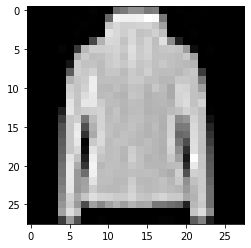

In [3]:
# select any random index from 1 to 60,000
i = random.randint(1,60000)
plt.imshow(X_train[i] , cmap = 'gray')

In [4]:
label = y_train[i]
label

4

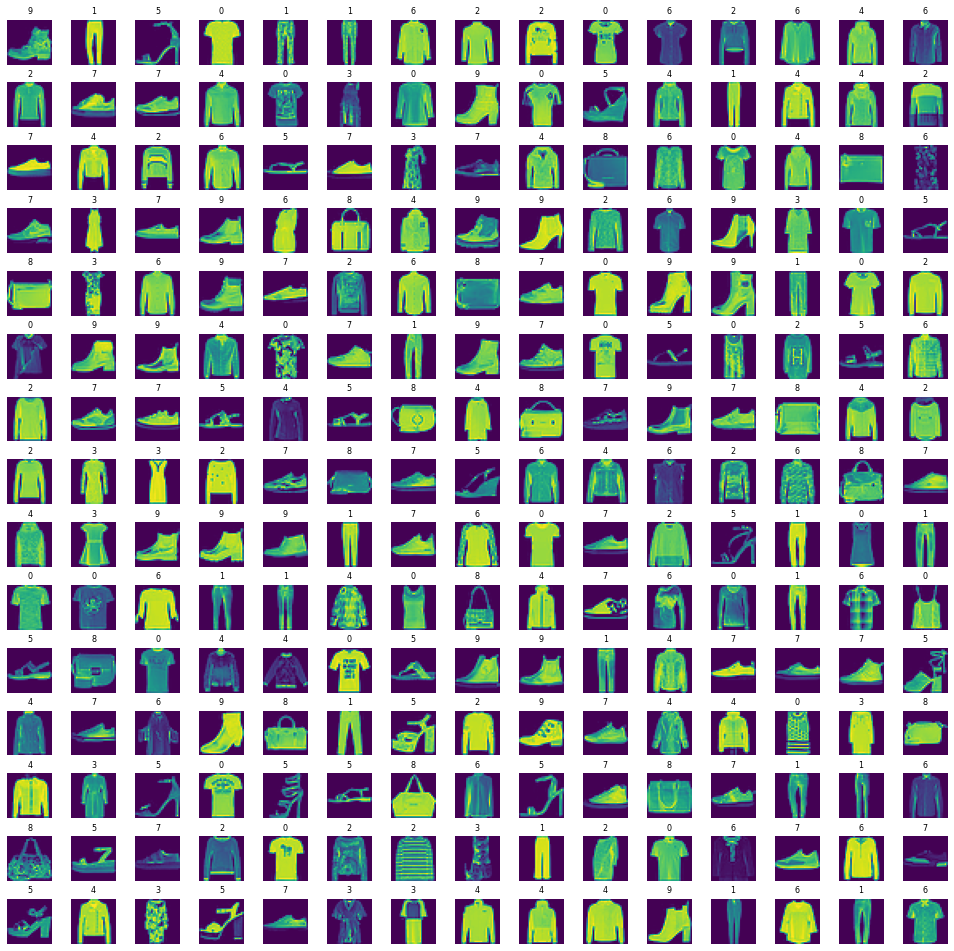

In [5]:
W_grid = 15
L_grid = 15

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))
axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array
n_training = len(X_train) # get the length of the training dataset

# Select a random number from 0 to n_training
for i in np.arange(0, W_grid * L_grid):
    index = np.random.randint(0, n_training)
    axes[i].imshow( X_train[index] )
    axes[i].set_title(y_train[index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

## 2. Preparación de datos

Para entrenar el modeo, realizamos una normalización de los datos para que se encuentren entre el rango [0,1]. Esto no se verá afectado en la construcción de la imagen.

In [6]:
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

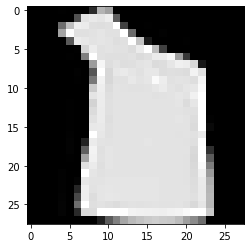

In [7]:
plt.imshow(X_train[10], cmap="gray")

## 3. Modelamiento

### 3.1 Arquitectura

Para el desarrollo del laboratorio se utilizará una arquitectura de Autoencoder estructurada de la siguiente manera:

![Autoencoder](https://github.com/jcestevezc/Machine-Learning-Techniques/blob/master/Laboratorio%206/Autoencoder.png?raw=true)

Los codificadores automáticos o autoencoders se utilizan para el preentrenamiento de otras redes, reducción de la dimensionalidad, aprendizaje de espacios latentes, entre otros.

Los autoencoders, por otro lado, pueden ser entrenados sin supervisión. Su estructura generalmente se caracteriza por: 
1. La cantidad de neuronas ocultas es menor que la cantidad de celdas de entrada.
2. La cantidad de celdas de salida es igual a la cantidad de celdas de entrada.
3. El autoencoder se entrena de manera en que la salida está lo más cerca posible de la entrada, obligando a los autoencoders a generalizar datos y realizar búsqueda de patrones comunes.

### 3.1.1. Modelado

In [8]:
autoencoder = Sequential(name="Autoencoder")

#Encoder
autoencoder.add(Conv2D(filters=16, kernel_size=3, strides=2, padding="same", input_shape=(28, 28, 1)))
autoencoder.add(Conv2D(filters=8, kernel_size=3, strides=2, padding="same"))

#Encoded image
autoencoder.add(Conv2D(filters=8, kernel_size=3, strides=1, padding="same"))

#Decoder
autoencoder.add(Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding="same"))
autoencoder.add(Conv2DTranspose(filters=1, kernel_size=3, strides=2, activation='sigmoid', padding="same"))

In [9]:
autoencoder.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(lr=0.001))
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 8)           1160      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 16)        1168      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 1)         145       
Total params: 3,217
Trainable params: 3,217
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [10]:
autoencoder.fit(X_train.reshape(-1, 28, 28, 1),          
                X_train.reshape(-1, 28, 28, 1), 
                epochs=20, 
                batch_size=200, 
                validation_data=(
                    X_val.reshape(-1, 28, 28, 1), 
                    X_val.reshape(-1, 28, 28, 1)
                    )
                )

Epoch 1/20
240/240 [==============================] - 13s 51ms/step - loss: 0.0499 - val_loss: 0.0178
Epoch 2/20
240/240 [==============================] - 12s 48ms/step - loss: 0.0146 - val_loss: 0.0125
Epoch 3/20
240/240 [==============================] - 12s 49ms/step - loss: 0.0112 - val_loss: 0.0099
Epoch 4/20
240/240 [==============================] - 12s 49ms/step - loss: 0.0088 - val_loss: 0.0079
Epoch 5/20
240/240 [==============================] - 12s 49ms/step - loss: 0.0074 - val_loss: 0.0070
Epoch 6/20
240/240 [==============================] - 12s 49ms/step - loss: 0.0066 - val_loss: 0.0062
Epoch 7/20
240/240 [==============================] - 12s 49ms/step - loss: 0.0059 - val_loss: 0.0056
Epoch 8/20
240/240 [==============================] - 12s 49ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 9/20
240/240 [==============================] - 12s 50ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 10/20
240/240 [==============================] - 12s 50ms/step - loss: 0.004

### 3.1.2. Predicción

In [11]:
predicted = autoencoder.predict(X_val[:10].reshape(-1, 28, 28, 1))

## 3.1.3. Validación

In [12]:
evaluation = autoencoder.evaluate(X_val.reshape(-1, 28, 28, 1), X_val.reshape(-1, 28, 28, 1))
print('Validation Accuracy : {:.3f}'.format(evaluation))

375/375 [==============================] - 2s 5ms/step - loss: 0.0037
Validation Accuracy : 0.004


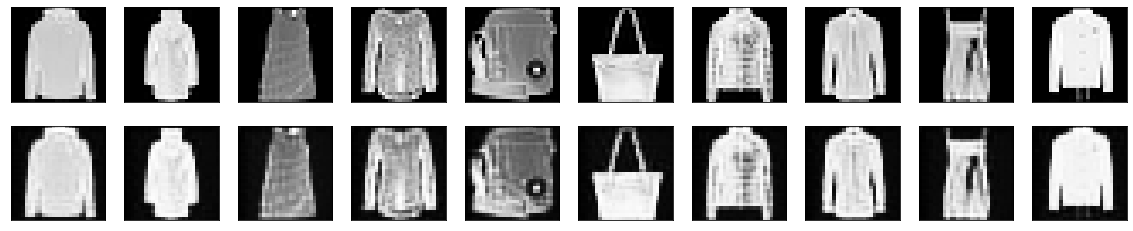

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))

for images, row in zip([X_val[:10], predicted], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## 3.1.4. Despliegue

In [14]:
predicted = autoencoder.predict(X_test[:10].reshape(-1, 28, 28, 1))
evaluation = autoencoder.evaluate(X_test.reshape(-1, 28, 28, 1), X_test.reshape(-1, 28, 28, 1))
print('Test Accuracy : {:.3f}'.format(evaluation))

313/313 [==============================] - 2s 6ms/step - loss: 0.0037
Test Accuracy : 0.004


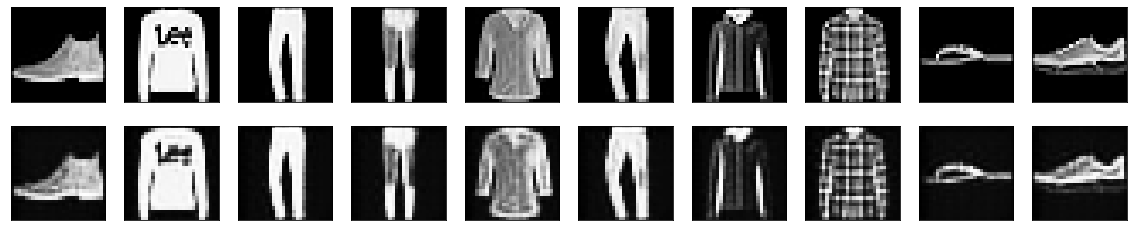

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))

for images, row in zip([X_test[:10], predicted], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

### 3.2 Denoising Autoencoder


Otra forma de entrenamiento de los Autoencoders es a través de un Denoising Autoencoder.

Se agrega ruido a los datos:

In [16]:
def noising_image(data, noise_factor):
  noise_dataset = []
  for img in data:
    noisy_image = img + noise_factor * np.random.randn(*img.shape)
    noisy_image = np.clip(noisy_image, 0., 1.)
    noise_dataset.append(noisy_image)
  
  noise_dataset = np.array(noise_dataset)
  return noise_dataset

In [17]:
X_train_noise = noising_image(X_train, 0.2)
X_val_noise = noising_image(X_val, 0.2)
X_test_noise = noising_image(X_test, 0.2)

In [18]:
print(X_train_noise.shape)
print(X_val_noise.shape)
print(X_test_noise.shape)

(48000, 28, 28)
(12000, 28, 28)
(10000, 28, 28)


Visualizamos como es el resultado de agregar ruido a una de las imagenes:

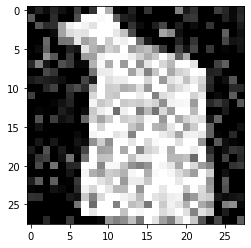

In [19]:
plt.imshow(X_train_noise[10], cmap="gray")

### 3.2.1. Modelado

In [20]:
autoencoder = Sequential(name="Denoising_Autoencoder")

#Encoder
autoencoder.add(Conv2D(filters=16, kernel_size=3, strides=2, padding="same", input_shape=(28, 28, 1)))
autoencoder.add(Conv2D(filters=8, kernel_size=3, strides=2, padding="same"))

#Encoded image
autoencoder.add(Conv2D(filters=8, kernel_size=3, strides=1, padding="same", name="encoder"))

#Decoder
autoencoder.add(Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding="same"))
autoencoder.add(Conv2DTranspose(filters=1, kernel_size=3, strides=2, activation='sigmoid', padding="same"))

In [21]:
autoencoder.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(lr=0.001))
autoencoder.summary()

Model: "Denoising_Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 8)           1160      
_________________________________________________________________
encoder (Conv2D)             (None, 7, 7, 8)           584       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 16)        1168      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 1)         145       
Total params: 3,217
Trainable params: 3,217
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [22]:
autoencoder.fit(X_train_noise.reshape(-1, 28, 28, 1),          
                X_train.reshape(-1, 28, 28, 1), 
                epochs=20, 
                batch_size=200, 
                validation_data=(
                    X_val_noise.reshape(-1, 28, 28, 1), 
                    X_val.reshape(-1, 28, 28, 1)
                    )
                )

Epoch 1/20
240/240 [==============================] - 12s 50ms/step - loss: 0.0545 - val_loss: 0.0220
Epoch 2/20
240/240 [==============================] - 12s 49ms/step - loss: 0.0187 - val_loss: 0.0166
Epoch 3/20
240/240 [==============================] - 12s 49ms/step - loss: 0.0156 - val_loss: 0.0147
Epoch 4/20
240/240 [==============================] - 12s 49ms/step - loss: 0.0142 - val_loss: 0.0136
Epoch 5/20
240/240 [==============================] - 12s 49ms/step - loss: 0.0131 - val_loss: 0.0127
Epoch 6/20
240/240 [==============================] - 12s 49ms/step - loss: 0.0124 - val_loss: 0.0121
Epoch 7/20
240/240 [==============================] - 12s 49ms/step - loss: 0.0119 - val_loss: 0.0116
Epoch 8/20
240/240 [==============================] - 12s 49ms/step - loss: 0.0115 - val_loss: 0.0113
Epoch 9/20
240/240 [==============================] - 12s 49ms/step - loss: 0.0113 - val_loss: 0.0111
Epoch 10/20
240/240 [==============================] - 12s 49ms/step - loss: 0.011

### 3.2.2. Predicción

In [23]:
predicted = autoencoder.predict(X_val_noise[:10].reshape(-1, 28, 28, 1))

### 3.2.3. Validación

In [24]:
evaluation = autoencoder.evaluate(X_val_noise.reshape(-1, 28, 28, 1), X_val.reshape(-1, 28, 28, 1))
print('Validation Accuracy : {:.3f}'.format(evaluation))

375/375 [==============================] - 2s 5ms/step - loss: 0.0103
Validation Accuracy : 0.010


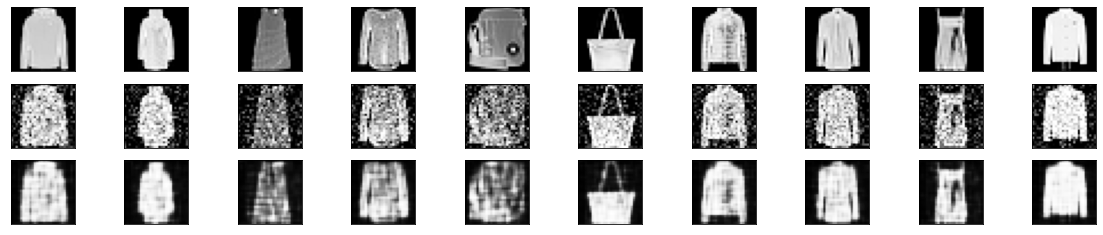

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=10, sharex=True, sharey=True, figsize=(20,4))

for images, row in zip([X_val[:10], X_val_noise[:10], predicted], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

### 3.2.4. Despliegue

In [26]:
predicted = autoencoder.predict(X_test_noise[:10].reshape(-1, 28, 28, 1))
evaluation = autoencoder.evaluate(X_test_noise.reshape(-1, 28, 28, 1), X_test.reshape(-1, 28, 28, 1))
print('Test Accuracy : {:.3f}'.format(evaluation))

313/313 [==============================] - 2s 5ms/step - loss: 0.0104
Test Accuracy : 0.010


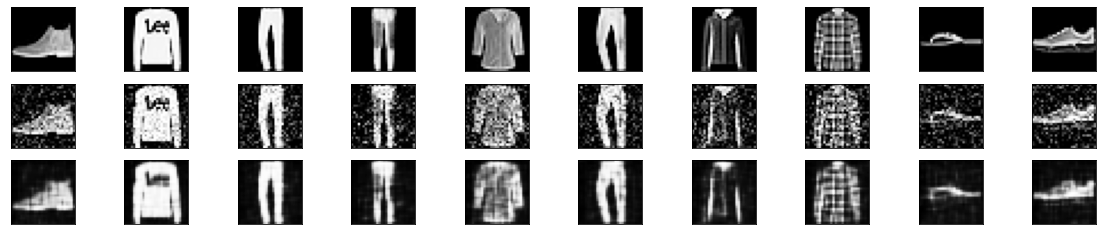

In [27]:
fig, axes = plt.subplots(nrows=3, ncols=10, sharex=True, sharey=True, figsize=(20,4))

for images, row in zip([X_test[:10], X_test_noise[:10], predicted], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## Transferencia de Conocimiento

In [28]:
encoder = Sequential(name='Encoder')

for layers in autoencoder.layers:
  print(layers.name)
  layers.trainable = False
  encoder.add(layers)
  if layers.name == "encoder":
    break

conv2d_3
conv2d_4
encoder


In [29]:
encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 8)           1160      
_________________________________________________________________
encoder (Conv2D)             (None, 7, 7, 8)           584       
Total params: 1,904
Trainable params: 0
Non-trainable params: 1,904
_________________________________________________________________


In [30]:
encoder.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [31]:
predicted = encoder.predict(X_test_noise[:10].reshape(-1, 28, 28, 1))

In [32]:
predicted[1]

array([[[-1.55965793e+00,  7.87458122e-01, -1.08503008e+00,
          2.27630687e+00,  2.82679296e+00,  6.33871615e-01,
         -1.31873703e+00, -9.53670919e-01],
        [-6.41354799e-01, -5.44244707e-01, -2.51006222e+00,
          1.08583617e+00, -1.99744448e-01, -2.72137475e+00,
          1.24895597e+00, -3.37620306e+00],
        [-1.41181922e+00, -4.36438173e-01, -1.82631969e-01,
          7.65171230e-01, -4.72784817e-01, -4.15728521e+00,
          2.07744694e+00, -1.69449162e+00],
        [-1.78278887e+00, -6.49762988e-01, -3.41945648e-01,
          1.19965219e+00, -2.42308125e-01, -3.76177597e+00,
          2.73559856e+00, -1.66152096e+00],
        [-1.21416318e+00,  5.32468200e-01, -1.62366009e+00,
          1.06795239e+00, -1.87312901e+00, -2.85819077e+00,
          2.23103237e+00, -8.33734751e-01],
        [-1.52490485e+00,  5.41098237e-01, -2.68288064e+00,
          1.33589721e+00, -1.52432883e+00,  2.18041372e+00,
          2.24752927e+00, -8.47600102e-01],
        [-2.2373